In [1]:
import numpy as np
import pandas as pd
import scipy
import cv2
import keras.backend as K
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
from inference.project import *

Using TensorFlow backend.


In [2]:
# Inputs (https://rgbd-dataset.cs.washington.edu/index.html)
input_img = cv2.imread('custom/apple.png', cv2.IMREAD_COLOR)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB) / 255
depth = cv2.imread('custom/apple_depth.png', cv2.IMREAD_UNCHANGED) / 1000
# Intrinsics
intrinsics = np.array([[570.3, 0, 320], [0, 570.3, 240], [0, 0, 1]])
intrinsics_inv = np.linalg.inv(intrinsics)

In [3]:
# Depth map to point cloud
depth_tensor = K.variable(np.expand_dims(depth, 0))
intrinsics_inv_tensor = K.variable(np.expand_dims(intrinsics_inv, 0))
points = K.eval(get_cloud(depth_tensor, intrinsics_inv_tensor))

# Create point cloud dataframe
points = np.reshape(points, points.shape[1:]) # Ignore batch size
points[:,:,0] *= -1 # Invert x axis
points[:,:,2] *= -1 # Invert z axis
points = np.reshape(points, (points.shape[0]*points.shape[1], 3)) # Reshape to (m*n,3)
colors = np.reshape(input_img, (input_img.shape[0]*input_img.shape[1], 3)) * 255 # Reshape to (m*n,3)
points_df = pd.DataFrame(np.concatenate((points, colors), axis=-1), 
                         columns=['x','y','z','red','green','blue'])

Instructions for updating:
Colocations handled automatically by placer.


W0521 18:51:31.166367 140015197132608 deprecation.py:323] From /home/alex/virtualenvs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


<IPython.core.display.Javascript object>


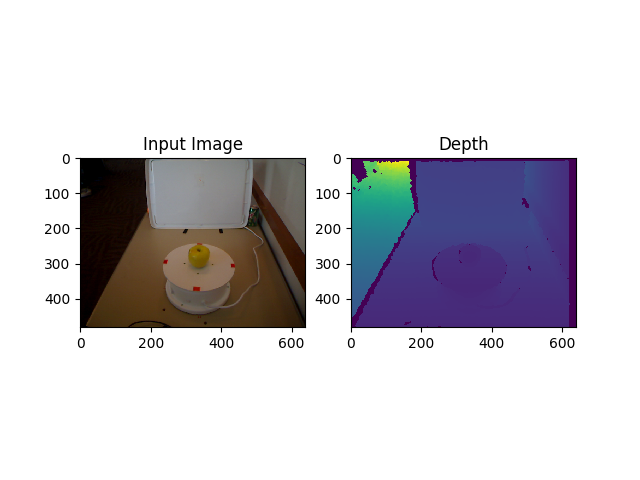

In [4]:
# Plot input and depth images
%matplotlib notebook
plt.subplot(121)
plt.title('Input Image')
plt.imshow(input_img)
plt.subplot(122)
plt.title('Depth')
plt.imshow(depth)
plt.show()

In [6]:
# Plot point cloud
point_cloud = PyntCloud(points_df)
point_cloud.plot(initial_point_size=0.001)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(0.15102135713331186, 0.5235307991271236, -1.…

In [7]:
# Generate masked point cloud
mask = cv2.imread('custom/apple_mask2.png', cv2.IMREAD_GRAYSCALE) / 255
masked_input = np.tile(np.expand_dims(mask, -1), (1,1,3)) * input_img
masked_depth = mask * depth
masked_depth_tensor = K.variable(np.expand_dims(masked_depth, 0))
masked_points = K.eval(get_cloud(masked_depth_tensor, intrinsics_inv_tensor))

masked_points = np.reshape(masked_points, masked_points.shape[1:]) # Ignore batch size
masked_points[:,:,0] *= -1 # Invert x axis
masked_points[:,:,2] *= -1 # Invert z axis
masked_points = np.reshape(masked_points, (masked_points.shape[0]*masked_points.shape[1], 3))
# Ignore points with depth=0 (unmasked)
depth_filter = np.reshape(masked_depth, (masked_depth.shape[0]*masked_depth.shape[1])) > 0
masked_points = masked_points[depth_filter, :]
masked_colors = np.reshape(masked_input, (masked_input.shape[0]*masked_input.shape[1], 3)) * 255 # Reshape to (m*n,3)
masked_colors = masked_colors[depth_filter, :]
masked_points_df = pd.DataFrame(np.concatenate((masked_points, masked_colors), axis=-1), 
                                columns=['x','y','z','red','green','blue'])

<IPython.core.display.Javascript object>


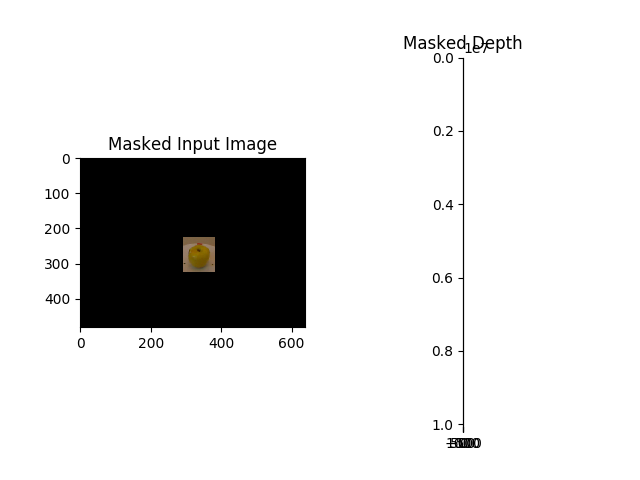

In [8]:
# Plot input and depth images
%matplotlib notebook
plt.subplot(121)
plt.title('Masked Input Image')
plt.imshow(masked_input)
plt.subplot(122)
plt.title('Masked Depth')
plt.imshow(masked_depth)
plt.show()

In [9]:
# Plot point cloud
masked_point_cloud = PyntCloud(masked_points_df)
masked_point_cloud.plot(initial_point_size=0.001)

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.023302736836145872, 0.14986044839840568, …

In [60]:
# Use mean k-nearest neighbors distance to determine RANSAC max fitting distance
kdtree = scipy.spatial.cKDTree(masked_points)
k = 10
distances, _ = kdtree.query(masked_points, k)
mean_distances = np.mean(distances[:, 1:])

is_floor = masked_point_cloud.add_scalar_field("plane_fit", max_dist=mean_distances)
masked_point_cloud.plot(initial_point_size=0.001, use_as_color=is_floor, cmap='cool')

Renderer(camera=PerspectiveCamera(aspect=1.6, fov=90.0, position=(-0.023302736836145872, 0.14986044839840568, …